# Understanding People with Network Graphs in Python

Now we can really start

## NetworkX

> NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks - https://networkx.org/

NetworkX provides an easy-to-use, *fast*, graph framework to represent relationships in-memory

In [5]:
import networkx as nx

G = nx.Graph()

It's easy to load in data one at a time

In [6]:
G.add_node("Me", type="person", languages=["Python"])

Or from an iterable object

In [7]:
G.add_nodes_from((
    ("You",dict(languages=["Python","Scala"])),
    ("Them",dict(languages=["Python","Javascript"]))
), type="person")

Now we can look at the new data structure and play around with it:

In [8]:
G.nodes() # show all the node labels

NodeView(('Me', 'You', 'Them'))

In [9]:
G.nodes(data=True) # show all attributes in nodes

NodeDataView({'Me': {'type': 'person', 'languages': ['Python']}, 'You': {'type': 'person', 'languages': ['Python', 'Scala']}, 'Them': {'type': 'person', 'languages': ['Python', 'Javascript']}})

In [10]:
G.nodes(data="languages") # show a specific attribute

NodeDataView({'Me': ['Python'], 'You': ['Python', 'Scala'], 'Them': ['Python', 'Javascript']}, data='languages')

In [11]:
G.add_edge("Me","You", label="friends") # add an edge connecting two nodes ...
G.add_edge("You","Them", label="friends") # add an edge connecting two nodes ...

There are lots of common and complex graph analysis functions available to make the most of the data structure 

In [12]:
nx.shortest_path(G, source="Me", target="Them") # find paths between nodes through edges

['Me', 'You', 'Them']

In [13]:
G.adj # find adjacent nodes

AdjacencyView({'Me': {'You': {'label': 'friends'}}, 'You': {'Me': {'label': 'friends'}, 'Them': {'label': 'friends'}}, 'Them': {'You': {'label': 'friends'}}})

And visualizing is built-in with `matplotlib`. We will pretty this up later with `plotly`

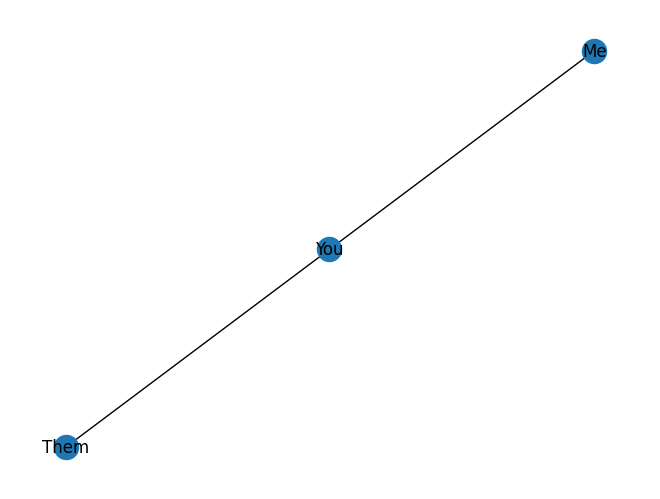

In [14]:
nx.draw(G, with_labels=True)

### Some People Data

Let's re-use what we made before:

In [2]:
%run "../Part 0 - The Data/Solution.ipynb"

Dr.
Mrs.
Ms.
Mr.
Mx.
Misc.
Miss
Ind.
😟


## The Graph

Now we're ready to define and populate the network graph. NetworkX provides helpful methods to populate the structure from an iterable. Here we massage our list of `people` a bit in order to give a unique name to each *node* in the graph:

In [15]:
from more_itertools import take

In [16]:
G = nx.Graph() # a simple undirected graph
G.add_nodes_from(((person["name"], person) for person in expanded_df.to_dict(orient="records")), person=True, type="person")
take(3, G.nodes(data=True)) # we can look at the contents (which should be very familiar!)

[('Amber Gates',
  {'person': True,
   'type': 'person',
   'name': 'Amber Gates',
   'hire_date': '20220131',
   'status': 'Part Time',
   'languages': ['Python', 'Java'],
   'manager': 'George Huffman',
   'team': 'Business',
   'title': 'Analyst',
   'location': {'city': 'New York', 'tz': 'EST', 'country': 'USA'},
   'rank': 1.0,
   'city': 'New York',
   'tz': 'EST',
   'country': 'USA'}),
 ('Daniel Thompson',
  {'person': True,
   'type': 'person',
   'name': 'Daniel Thompson',
   'hire_date': '20210223',
   'status': 'Full Time',
   'languages': ['JavaScript'],
   'manager': 'George Huffman',
   'team': 'Business',
   'title': 'Analyst',
   'location': {'city': 'New York', 'tz': 'EST', 'country': 'USA'},
   'rank': 1.0,
   'city': 'New York',
   'tz': 'EST',
   'country': 'USA'}),
 ('Debra Sanders',
  {'person': True,
   'type': 'person',
   'name': 'Debra Sanders',
   'hire_date': '20210510',
   'status': 'Part Time',
   'languages': [],
   'manager': 'Michelle James',
   'team'

### Visualizing

Graphs lends themselves well to visual representations. NetworkX also makes this easy to do by tapping into Python's workhorse plotting library, `matplotlib`. We will revisit this later with a more dynamic + interactive approach to visualizing, but for the moment this is the fastest way to get things on paper

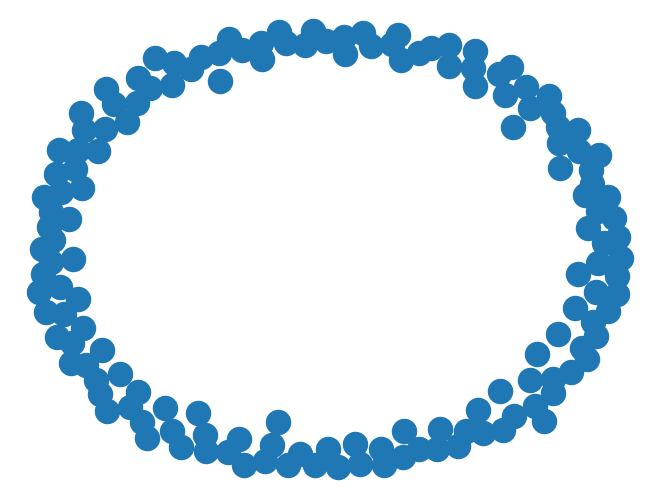

In [17]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=False)

Let's add a bit of color to this by mapping colors to the `person.team`. Pick any colorscale from `px.colors` (or make your own!). Generally the *qualitative* colors look nice, anything designed for *categorical* data 

In [19]:
colors = dict(zip(people_df.team.unique(),px.colors.qualitative.Vivid))
colors

{'Business': 'rgb(229, 134, 6)',
 'DevOps': 'rgb(93, 105, 177)',
 'DevX': 'rgb(82, 188, 163)',
 'Internal Tools': 'rgb(153, 201, 69)',
 'Platform': 'rgb(204, 97, 176)',
 'Product': 'rgb(36, 121, 108)',
 'Sales': 'rgb(218, 165, 27)',
 'Support': 'rgb(47, 138, 196)',
 'CEO': 'rgb(118, 78, 159)'}

In [20]:
# here are some helpful helpers to translate colors
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'
def rgb_string_to_tuple(rgb:str) -> tuple[int,int,int]:
    return tuple(int(c) for c in rgb.replace("rgb(","").replace(")","").split(","))


Now we can determine what the color should be for each node and pass that into the `nx.draw` call as a list of `node_color`. The easiest way to do this is to use `G.nodes(data=...)` for the attribute you want to extract, which will give you a map from each node to that attribute. `nx` allows you to iterate

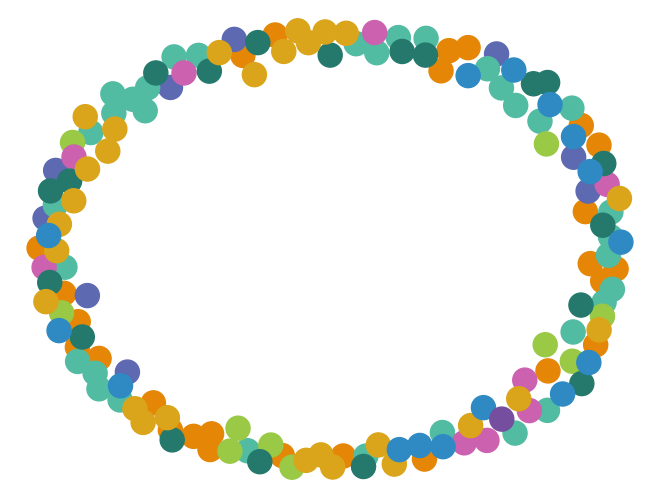

In [21]:
node_colors = [rgb_to_hex(*rgb_string_to_tuple(colors[team])) for _,team in G.nodes(data="team")]
nx.draw(G, node_color=node_colors)

If this doesn't make much sense yet, it's because we haven't connected any of the nodes together. Adding *edges* to the graph will give shape and meaning to the arrangement of nodes. We can do this similarly to how we added edges. Let's start by connecting nodes by the `manager` attribute.

Be sure to only add edges that reference nodes that exist

In [22]:
G.add_edges_from(G.nodes(data="manager"), label="manager", manager=True)

Now this should look a bit more sensible

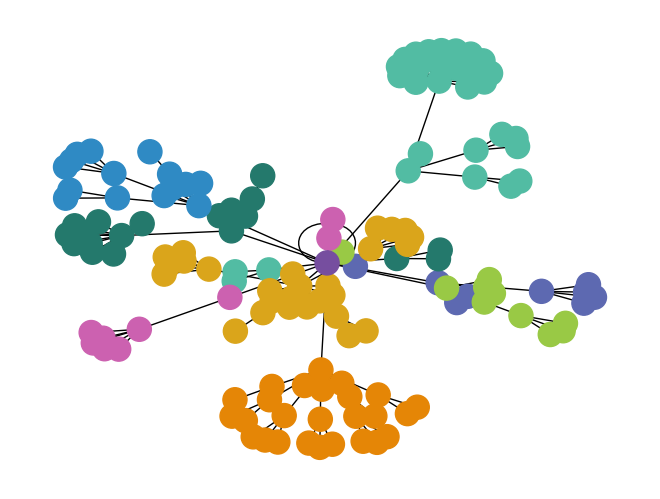

In [23]:
nx.draw(G, node_color=node_colors)

**What are 3 more tests we can do now to check this graph structure matches our statistical understanding of the tabular data?**

1. ?
2. ?
3. ?


To view more details of the plot, it's useful to switch to an interactive plotting library like `plotly`. Here we provide a helper function for this, but by no means is this perfect/optimized

In [24]:
import pandas as pd
import plotly.express as px

In [25]:
import plotly.graph_objects as go
def px_plot_network_graph_nodes(G:nx.Graph, *, layout=None, **pxkwargs) -> go.Figure:
    # generate the x/y coordinates to represent the graph
    positions = (layout or nx.spring_layout(G))
    # prepare as DataFrame for plotly
    df = pd.DataFrame([{"label": k, "x": v[0], "y": v[1], "size":10, **G.nodes(data=True)[k]} for k,v in positions.items()])
    for column in df.columns[(df.sample(100, replace=True).applymap(type) == set).any(axis=0)]:
        print(f"Coercing column '{column}' to `list`")
        df.loc[~df[column].isna(), column] = df.loc[~df[column].isna(),column].apply(list)
    # handle missing values for size/color parameter
    size = pxkwargs.pop("size", "size")
    df[size] = df[size].fillna(df[size].max())
    color = pxkwargs.get("color")
    df[color] = df[color].fillna(df["type"])
    # create figure
    fig = px.scatter(df, x="x", y="y", hover_data=df.columns, size=size, **pxkwargs)
    fig.update_layout(
        xaxis=go.layout.XAxis(visible=False),
        yaxis=go.layout.YAxis(visible=False)
    )
    return fig


def px_plot_nx(G:nx.Graph, *, layout=nx.spring_layout, with_edges=False, **nodekwargs) -> go.Figure:
    """Draw a graph using ``plotly``

    Kwargs are passed through to `px.scatter` and can be used to control the attributes that 
    map ``color``, ``size``, ``facet_row``, ... to attributes in the graph nodes
    
    Notes
    -----
    Rendering ``with_edges`` is expensive and should be avoided during exploratory plotting
    """
    # Generate positions, edges 
    nodes = layout(G)
    edges = [{
        "x": [nodes[source][0],nodes[target][0]], 
        "y": [nodes[source][1],nodes[target][1]]} for source, target in G.edges()
    ]
    # Plot nodes
    figure = px_plot_network_graph_nodes(G, layout=nodes, **nodekwargs)
    if with_edges: # Add edges to nodes
        figure.add_traces([
            px.line(
                x=edge["x"],
                y=edge["y"],
                color_discrete_sequence=["grey"],
            ).data[0] for edge in edges
        ])
        figure.data = figure.data[::-1] # shuffle edges behind nodes
    return figure

Use this to make a few plots of the graph and verify that:

* The reporting structure makes sense
* The job titles are distributed as you'd expect
* The locations make sense

**Note: plotting `with_edges=True` is quite expensive, try toggling it off if you find it bothersome**

In [26]:
from functools import partial

layout = (
    nx.spring_layout
)  # partial(nx.spring_layout,k=0.1, iterations=20) # or customize how the layout is generated
px_plot_nx(
    G,
    color="country",
    layout=layout,
    with_edges=False,
    hover_name="name",
    size="rank",
    template="plotly_dark",
)  # ,text="label")


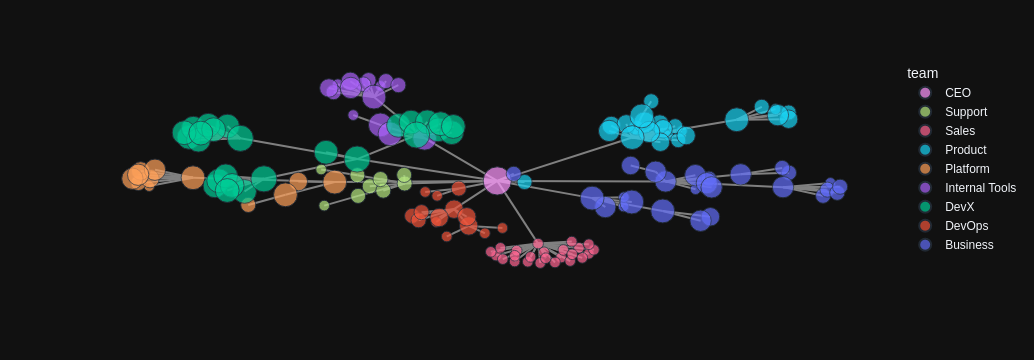

In [131]:
px_plot_nx(
    G,
    color="team",
    layout=layout,
    with_edges=False,
    hover_name="name",
    size="rank",
    template="plotly_dark",
)  # ,text="label")


## Pyvis

Alas -- there is another way to visualize our `networkx` graph using `VisJS` (via [pyvis](https://pyvis.readthedocs.io/en/latest/introduction.html))

Unfortunately the output [won't render in VSCode](https://github.com/microsoft/vscode-jupyter/issues/12689) ... but if you're in Jupyter or view the html file in a browser you're cooking

In [27]:
from IPython.display import display
from pyvis.network import Network
nt = Network(notebook=True, cdn_resources="in_line", bgcolor="black")
# populates the nodes and edges data structures
nt.from_nx(G)

#nt.show('nx.html')

`pyvis` will prettify your graph for you if you include attributes:
* group: is this part of a group? It will be coloured as such
* title: hover text
* label: displayed under the node

So let's change our attribute name for the reserved keyword `title`

In [27]:
H = G.copy()  # let's make a copy before mutating this
# fix reserved names 
nx.set_node_attributes(H, {name: _title for name, _title in G.nodes(data="title")}, "_title")

We can adjust our current graph to render useful information with a fun plotting function

In [28]:
def nt_show(G: nx.Graph, color:str=None, title:str=None, label:str=None, size:str=None, legend:bool=True, **network_kwargs):
    """Draw a graph using ``pyvis``

    Parameters
    ----------
    color: str
        the name of the attribute to color nodes by
    title:str
        the name of the attribute to generate hover data titles
    label:str
        the name of attribute to print text labels
    legend:bool
        whether to include a janky legend
    size:str
        the attribute to size nodes by
    **network_kwargs
        passed through to `pyvis.network.Network` and can be used to customize how the plot is rendered

    """
    H = G.copy()
    nx.set_node_attributes(H, {name: color for name, color in G.nodes(data=color) if color}, "group")
    nx.set_node_attributes(H, {name: title for name, title in G.nodes(data=title) if title}, "title")
    nx.set_node_attributes(H, {name: label for name, label in G.nodes(data=label) if label}, "label")
    nx.set_node_attributes(H, {name: size for name, size in G.nodes(data=size) if size}, "size")
    if legend:
        add_legend_nodes(H)        
    default_kwargs = dict(notebook=True, cdn_resources="in_line")
    nt = Network(**default_kwargs|network_kwargs)
    nt.from_nx(H)
    return nt.show("nx.html");


def add_legend_nodes(G:nx.Graph):
    # Add Legend Nodes
    step = 100
    x = -500 * 2
    y = -500 * 2
    groups = set(group for _, group in G.nodes(data="group"))
    legend_nodes = [
        (
            group, 
            {
                'group': group, 
                'label': group,
                'size': 50, 
                # 'fixed': True, # So that we can move the legend nodes around to arrange them better
                'physics': False, 
                'x': f'{x}px', 
                'y': f'{y + legend_node*step}px',
                'shape': 'box', 
                'widthConstraint': step * 2, 
                'font': {'size': 30}
            }
        )
        for legend_node, group in enumerate(groups) if group
    ]
    G.add_nodes_from(legend_nodes)

In [28]:
# nt_show(H, color="team", label="_title", title="city", bgcolor="black")

## Gravis

https://robert-haas.github.io/gravis-docs/index.html

This package can be used for quickly generating interactive visualizations of moderately sized graphs (<10000 nodes to be possible, <1000 nodes to be fluid), which can be directed or undirected and may contain self-loops and multiedges. There are some scenarios where gravis might be especially useful

In [36]:
import gravis as gv

In [30]:
gv.vis(H)

In [31]:
gv.d3(H)

In [37]:
gv.three(H)

### Visualizing High Dimensional Data

Here ^ we took a stab at representing our data in a higher dimension (3) and plotting it as is. This is great! But it won't always work. What problems might there be with representing our data in 3 dimensions? What about in 2 dimensions?

Some other approaches:

* Reduce dimensionality and visualize (t-SNE)
* That's kind of what we're already doing but it's better